In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [16]:
words = open("video_2_dependencies/names.txt").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [17]:
len(words)

32033

In [18]:
chars = sorted(list(set("".join(words))))
stoi = {s: idx + 1 for idx, s in enumerate(chars)}
stoi["."] = 0
itos = {idx: s for s, idx in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [19]:
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0]*block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [20]:
#We expect at init, each token as uniform prob (1/27), thus init loss should be...
-torch.log(torch.tensor(1/27))

tensor(3.2958)

In [21]:
#4-D example at init
logits = torch.tensor([-3.0, 5.0, 0.0, 2.0])
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()
print(loss)

tensor(5.0553)


Very high loss because non-uniform logits/probs, where by chance high value corresponds to wrong logit/token/output

To remedy this, we want to remove the presence of these extreme values, and instead init Ws such logit values are close to 0 

In [22]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator= g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator = g)
b1 = torch.randn(n_hidden, generator = g)
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01 #Ensures logits are small
b2 = torch.randn(vocab_size, generator = g) * 0 #Since, we want logits roughly 0 at init, dont want to add bias at start, so make 0

parameters = [C, W1, b1, W2, b2]

print(sum([p.nelement() for p in parameters]))

for p in parameters:
    p.requires_grad = True

11897


In [23]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())


      0/ 200000: 3.3221
  10000/ 200000: 2.1900


KeyboardInterrupt: 

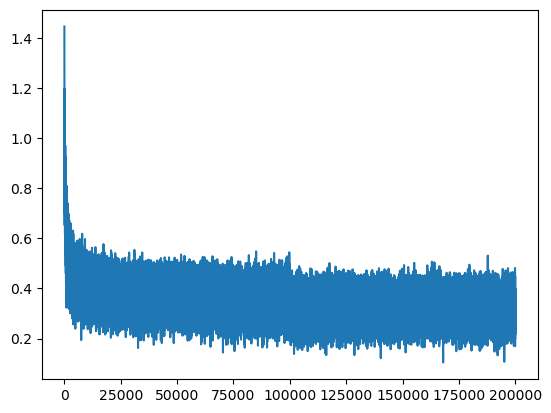

In [ ]:
plt.plot(lossi)

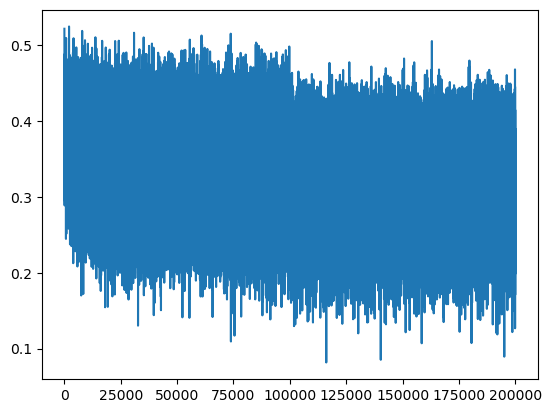

In [ ]:
plt.plot(lossi)

Note: There is no hockey stick in graph when init better, where optimization is squashing down the logits then rearranging the logits. We have removed the "easy gains" during optimization, and instead only focus on getting the "hard gains" of training a NN. This can be seen in the test and val performance, where loss has decreased, because now we have spent more cycles/time actually optimizing the NN, rather then squashing down the weights (which in turn leads to high logits)

In [ ]:
@torch.no_grad() #Disables gradient tracking of following function, more efficient as does not need to maintain computational graph for the below computations

def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss("train")
split_loss("val")

train 2.0695888996124268
val 2.131074905395508


In [ ]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator= g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator = g)
b1 = torch.randn(n_hidden, generator = g)
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01 #Ensures logits are small
b2 = torch.randn(vocab_size, generator = g) * 0 #Since, we want logits roughly 0 at init, dont want to add bias at start, so make 0

parameters = [C, W1, b1, W2, b2]

print(sum([p.nelement() for p in parameters]))

for p in parameters:
    p.requires_grad = True

11897


In [ ]:
h

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

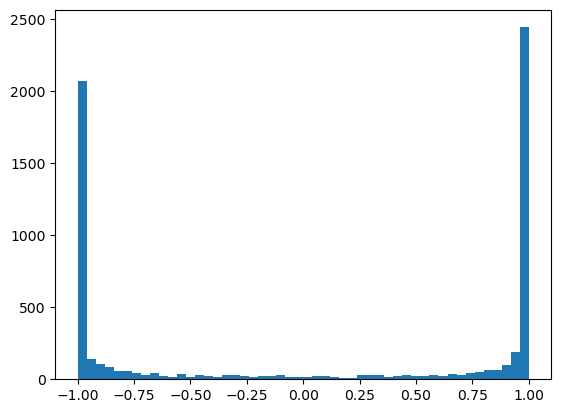

In [ ]:
plt.hist(h.view(-1).tolist(), 50);
#We can most of the values taken on valus of 1 or -1; this tanH is very active

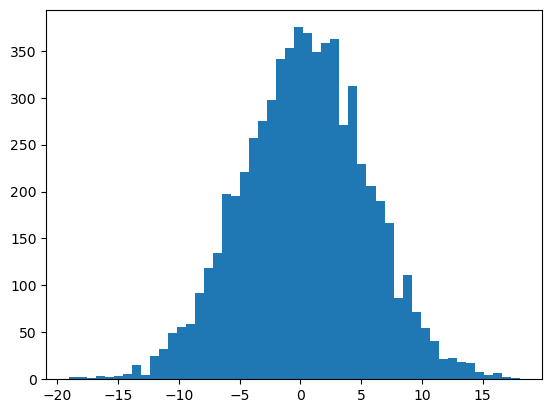

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50);

#Looking at the pre-activations feeding into TanH, can see that it is very broad, and when squashed by TanH, many numbers here take extreme values when TanH is applied (creates a dist. to saturated on both sides of TanH)

However, having TanH outputs skewed to 1 or -1 is problematic because the local gradient of tanh function h = tanh(z) is Dh/Dz = 1 - tanh(z)**2, where if tanh(z) == 1 or -1, then Dh/Dz == 0, and thus, when computing DL/Dz = DL/Dh * Dh/Dz = 0, thus killing the gradient and stopping backprop


This intuitevly makes sense, because if the output of tanh is close to 1 or -1, then we are in the tail of tanH, and so changing the input is not going to impact the output of TanH too much, as it is in the Flat region of Tanh, and thus their is no impact on the loss. Thus the weights and biases along with this Tanh neuron do not impact the loss, since the output of TanH unit is flat region and their is no infleunce to loss when we alter the inputs to it however we want

Interestingly, a gradient passing through TanH can only decrease, the amount it decreaes it proportional depeneding how far you are in the flat tails of TanH

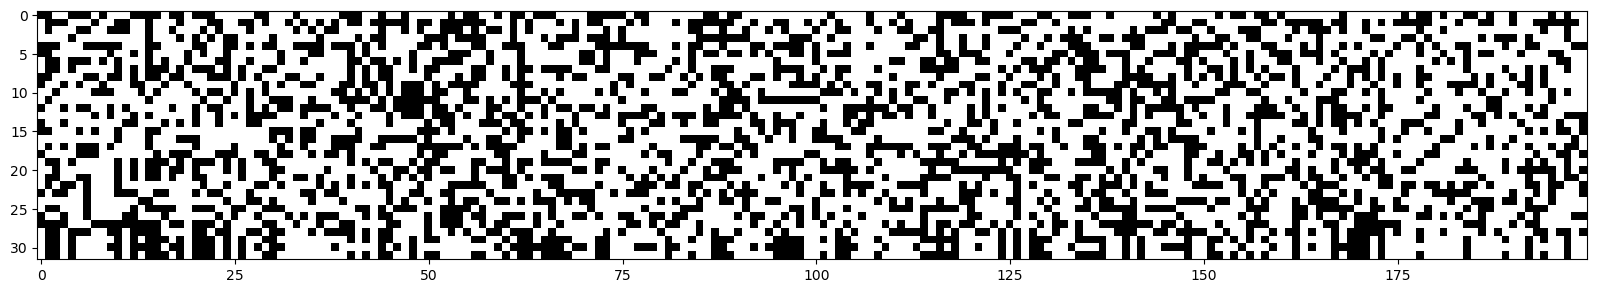

In [ ]:
plt.figure(figsize = (20, 10))
plt.imshow(h.abs() > 0.99, cmap = "gray", interpolation= "nearest")
#32 examples by the 200 neurons (where an element wise tanh is applied)
#white if in flat region, black if not in flat region
#we can see that alot of tanh neurons are active (has white)

We would be in a lot of trouble if for any of the neurons, the entire column was white, as this depicts the presence of a dead neuron, where due to the init of w and b, no single example activates tanh in the non-flat regions. If all examples land in tail, its weights and bias will never learn; a dead neuron

Since it is not the case for above, some gradients will flow through for each neuron, and it will learn

Same problems can exist for sigmoid and relu

This can arise duing init, but can also arise during optimization, where use too high of LR, then instances where neuron gets too high of gradient, it can get knocked out of the data manifold and then from then on, no example ever activates that neuron and it remains dead forever 

Leaky RelU does not have this problem, as it does not have flat tail

We want to imrpove on this, despite no dead neurons, because it means there is less training for these neurons, as they update less frequently

In [ ]:
n_embed = 10
n_hidden = 200

#Similiar to how we modified W2 and b2 such that logits are close to 0, we also need to modify weights below
#such that hpreact (pre-activations) are close to 0, to reduce tanH saturation

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator= g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator = g) * 0.2
b1 = torch.randn(n_hidden, generator = g) * 0.01 #We opted to use 0.01 instead of 0, such that there is a little bit of variation and diversity in the original init of the TanH neurons
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01 
b2 = torch.randn(vocab_size, generator = g) * 0 

parameters = [C, W1, b1, W2, b2]

print(sum([p.nelement() for p in parameters]))

for p in parameters:
    p.requires_grad = True

11897


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


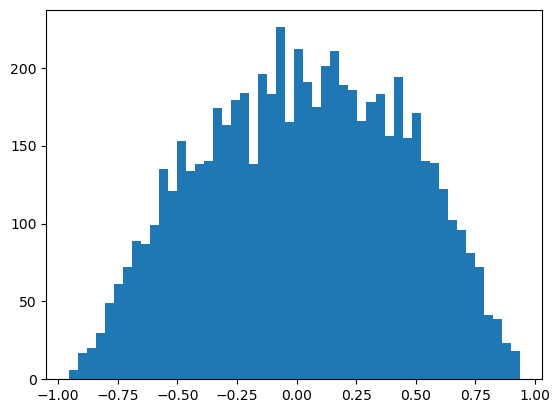

In [ ]:
plt.hist(h.view(-1).tolist(), 50);

#By making the preactivations in a small range, have a much better distribution for the activations

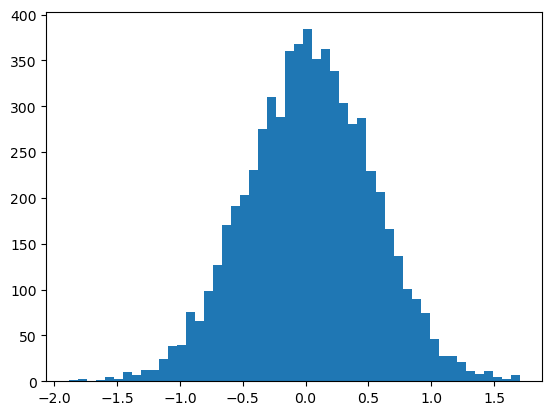

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50);

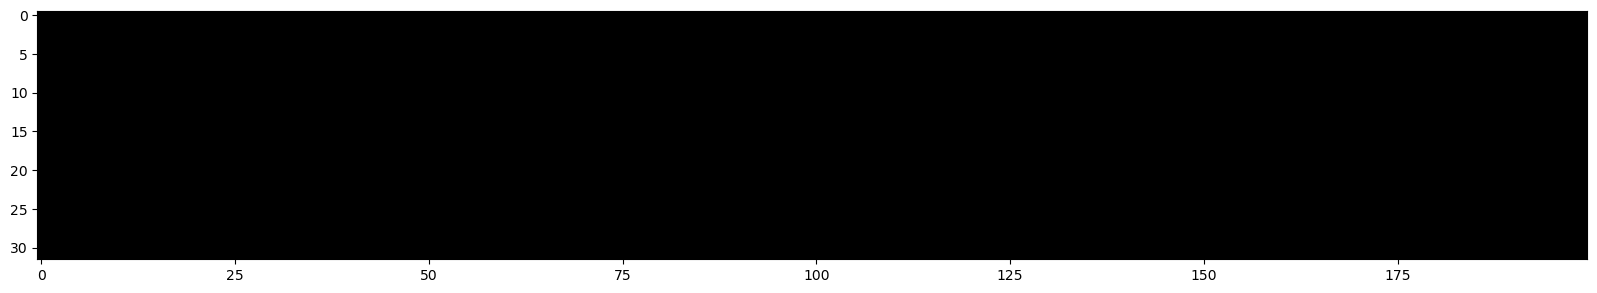

In [ ]:
plt.figure(figsize = (20, 10))
plt.imshow(h.abs() > 0.99, cmap = "gray", interpolation= "nearest")

#No neurons were saturated above 0.99

In [ ]:
@torch.no_grad() #Disables gradient tracking of following function, more efficient as does not need to maintain computational graph for the below computations

def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss("train")
split_loss("val")

train 2.0355966091156006
val 2.102678060531616


Get further improvements in val loss, by ensuring tanh is not too saturated at init; allowing for more time to do productive training

The deeper and more complex the NN, the less forgiving making these errors becomes

tensor(-0.0005) tensor(0.9976)
tensor(-0.0116) tensor(3.1093)


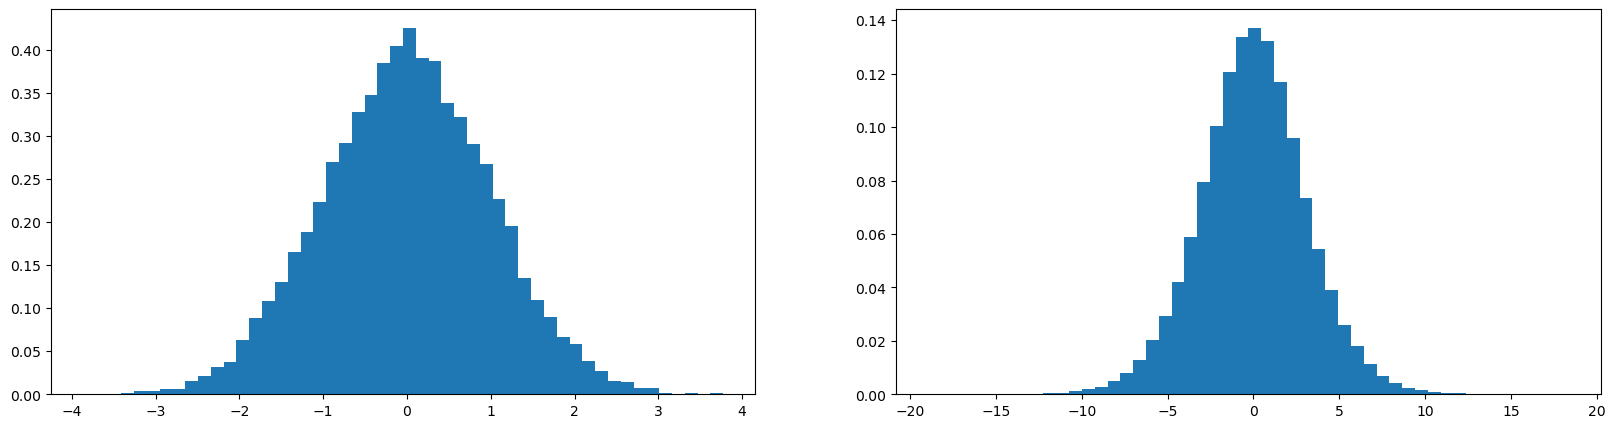

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w

#plotting inputs and preactivations
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True);

We can see the guassian has expanded from inputs, to activations, as STD has increased from 1 to 3
We want most of the NN to have unit guassian throughout

So we need to scale these Ws to preserve unit guassian

tensor(-0.0160) tensor(0.9952)
tensor(0.0008) tensor(1.0167)


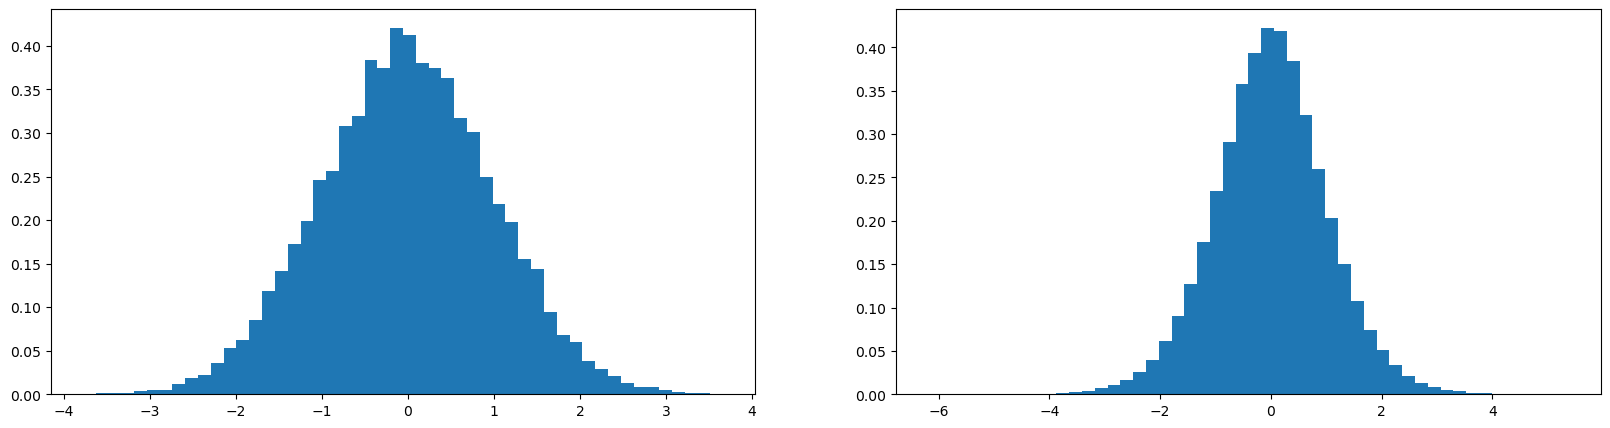

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w

#plotting inputs and preactivations
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True);

Have now retained the STD to be close to 1

Goal: Ensure during optimization that activations either do not expand to infinity or shrink to 0

"Kaiming init" Paper found that proper init of W to normalize the activations will ensure gradients behaviour appropriately (use fan_in)

Modern innovations such as residual connections, batchnorm/layernorm etc... and optimizers such as ADAM have made it less important to precisely init NN, but lets use Kaining init below...

In [ ]:
torch.randn(1000).std() * 0.2
#Note, whenver muliply entire distribution by value, alters STD

tensor(0.1953)

In [ ]:
(5/3) / (30**0.5)
#Determined by paper gain/(fan_in**0.5), we use 30 since input to NN = 30D

0.3042903097250923

In [ ]:
n_embed = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator= g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator = g) * (5/3) / ((n_embed*block_size)**0.5)
b1 = torch.randn(n_hidden, generator = g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01 
b2 = torch.randn(vocab_size, generator = g) * 0 

parameters = [C, W1, b1, W2, b2]

print(sum([p.nelement() for p in parameters]))

for p in parameters:
    p.requires_grad = True

11897


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


In [ ]:
@torch.no_grad() #Disables gradient tracking of following function, more efficient as does not need to maintain computational graph for the below computations

def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss("train")
split_loss("val")

train 2.0376641750335693
val 2.106989622116089


BatchNorm was important to allowing for deep NNs to be trained reliably 

Recall: We dont want large pre-activations since tanH will become saturated, but also pre-activations which are too small will not do anything (ex. tanh(0) = 0); we want them to be roughly guassian

The idea behind batchnorm, is to just normalize the hidden states/pre-activations, as it is a  differentiable operation

In [ ]:
hpreact.mean(0, keepdim = True) #Do mean over all the elements in the batch

tensor([[ 2.6620e-01, -2.0412e-01, -7.6152e-01,  5.1596e-01,  4.7110e-03,
         -2.3604e-01,  1.4135e+00, -7.5255e-01, -5.8233e-01,  3.0764e-01,
         -9.2775e-01, -1.1723e+00,  2.8912e-01, -2.5272e-02,  5.5815e-01,
         -4.2209e-01,  8.9884e-01, -1.2233e+00, -3.2833e-01,  3.6748e-01,
          9.3909e-01,  2.2445e-01,  8.0825e-01, -5.1821e-01,  4.2061e-01,
          6.5665e-01, -6.0714e-01, -5.6221e-01,  6.6641e-01,  1.1530e+00,
         -4.8799e-01, -1.1430e-01, -1.5771e+00, -2.6193e-01,  1.2589e-01,
         -1.6302e+00,  4.0173e-01, -1.1345e-01, -1.7193e+00, -3.0711e-01,
          1.1164e-01, -6.2975e-01, -2.1443e-01,  2.1155e-01,  3.1164e-01,
         -1.1505e+00,  5.7732e-01, -1.9744e-03,  6.8404e-01,  1.1366e+00,
          3.3672e-01, -8.0334e-01,  9.0461e-01,  6.3770e-01,  1.0200e+00,
         -1.8753e-01, -2.5862e-01,  1.4442e+00,  2.8982e-01, -3.6031e-01,
          2.1151e-01,  8.8042e-01, -8.7322e-03, -1.8613e-01,  6.7011e-01,
          9.8691e-01,  7.6257e-01,  8.

In [ ]:
hpreact.std(0, keepdim = True) #Do std over all the elements in the batch

tensor([[1.9613, 1.3486, 2.6169, 2.9698, 2.7784, 2.1968, 2.1737, 3.2098, 1.8199,
         1.9680, 1.8995, 1.9896, 1.0718, 2.4876, 1.9648, 1.7460, 2.8172, 2.7818,
         2.6821, 2.4640, 2.6209, 3.3154, 1.6177, 2.3900, 2.4985, 1.7149, 2.0246,
         2.5168, 2.8657, 2.4524, 1.6224, 1.8967, 2.7733, 1.6037, 1.5137, 2.2101,
         2.4012, 2.3304, 2.0241, 1.8732, 1.4424, 2.1492, 1.6517, 1.5745, 1.8599,
         1.9858, 1.9352, 2.8817, 1.7111, 2.4724, 2.0803, 2.0884, 1.9877, 2.0851,
         1.7538, 2.4325, 1.8240, 2.4118, 2.6271, 1.5493, 1.7387, 2.2251, 1.7173,
         1.3836, 2.9623, 1.6185, 1.7514, 2.0846, 2.2292, 2.5179, 2.4438, 1.4803,
         1.5512, 2.4341, 1.5833, 1.7891, 2.3643, 2.0278, 1.3426, 2.3906, 1.8960,
         2.4052, 1.6073, 2.6124, 2.5638, 2.3395, 1.9467, 2.4481, 2.1223, 2.2248,
         2.2783, 2.2455, 1.9989, 2.1342, 2.4529, 1.8233, 2.5712, 1.5163, 2.1924,
         2.2141, 2.3564, 2.3831, 2.9241, 2.2520, 1.9678, 1.5307, 2.4070, 1.6361,
         2.2437, 1.4952, 2.4

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = (hpreact - hpreact.mean(0, keepdim = True))/hpreact.std(0, keepdim = True)
    #Now every single neuron will be exactly unit guassian on the examples within the batch used to compute mean and std
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

However, we only want these pre-activations to be roughly guassian dist. at init, and allow the NN to move it around, more diffuse, more sharp, make some tanH neurons more trigger happy or less trigger happy; and want backprop to tell how it should move around

So add a scale and shift, to scale and shift the normalized pre-activations 

In [ ]:
n_embed = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator= g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator = g) * (5/3) / ((n_embed*block_size)**0.5)
b1 = torch.randn(n_hidden, generator = g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01 
b2 = torch.randn(vocab_size, generator = g) * 0 

bngain = torch.ones((1, n_hidden)) #scale
bnbias = torch.zeros((1, n_hidden)) #shift

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum([p.nelement() for p in parameters]))

for p in parameters:
    p.requires_grad = True

12297


In [41]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True))/hpreact.std(0, keepdim = True) + bnbias
    #Now every single neuron will be exactly unit guassian on the examples within the batch used to compute mean and std
    #Also scaled and shifted, but during init since bngain =1 and bnbias = 0, output will be unit guassian for each neuron
    #During backprop, will update bngain and bnbias such that NN has full ability to do whatever it wants internally
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 2.2001
  10000/ 200000: 2.1128
  20000/ 200000: 2.2711
  30000/ 200000: 2.2860
  40000/ 200000: 2.3612
  50000/ 200000: 2.1604
  60000/ 200000: 1.9890
  70000/ 200000: 2.2360
  80000/ 200000: 2.1051
  90000/ 200000: 2.2448
 100000/ 200000: 2.4320
 110000/ 200000: 2.0784
 120000/ 200000: 2.3158
 130000/ 200000: 1.8012
 140000/ 200000: 2.2479
 150000/ 200000: 1.6857
 160000/ 200000: 1.9784
 170000/ 200000: 2.1346
 180000/ 200000: 2.0294
 190000/ 200000: 1.9960


In [42]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)
  
#Now have fixed values during test time

In [43]:
bnmean, bnstd

(tensor([[-3.6446, -0.9697, -4.2660,  3.0765,  0.9767,  2.8376,  4.4630, -3.9417,
          -0.3987,  2.0951, -1.3376, -5.1762,  0.3455,  0.9551,  1.9821,  2.3371,
           2.7174, -4.2715, -4.1290,  3.7773,  1.9266, -1.6135,  0.9285,  0.3054,
           1.0953,  2.3288,  3.3988,  0.0101,  0.9667,  1.2164, -1.2617, -2.0863,
          -0.1992, -0.4987, -2.2074, -1.9219, -1.5526, -1.5106, -0.0298,  3.6017,
          -0.3700, -2.6425,  0.2700, -1.3912, -0.3437, -0.2703,  0.1252, -2.2252,
           2.9992,  2.0898,  1.3860, -0.8998,  2.4053,  4.1646,  1.5799, -2.6770,
          -0.0114,  2.3547,  4.9538, -0.1933, -1.2713,  2.6397,  1.4833, -0.1564,
           3.0379,  2.9041,  2.6637,  1.5547, -1.1534,  0.9537,  1.2363,  0.6870,
           3.2452, -2.5257, -3.2865, -0.7538,  3.1417, -0.4625,  2.2243,  0.4396,
           3.4820,  4.8032,  1.5908,  0.7776,  0.7126, -0.9418, -2.3459, -0.0075,
           2.7904,  1.0271,  2.5708,  2.5316, -0.6641, -1.1689, -0.2328, -1.6887,
          -2.007

In [44]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.1057968139648438
val 2.13655161857605


We dont notice improvement here, because NN is so simple and our kaiming init approach was sufficient, but for more complex NN, it will be more difficult to manully init weights such that pre-activations have a roughly guassian shape

One thing to realize about batch norm is that the mean and std of the batches are now coupled in the forward and backward pass of each example. A side effect of this is that sample example 1, when used in two different batch of differnt examples, will give a slightly differnt/jittery pre-activation (since mean and std across batches differ) -> activation -> logits. This interestingly is "good" as it can be thought of having as a regularizing effect, where it introduces some entropy (can be thought of as data augmentation) for sample example 1; thus making it harder for NN to overfit to these concrete specific examples

Often instead of computing mean and std on the entire training data, can do so in a running manner during training (called buffers)

In [54]:
n_embed = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator= g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator = g) * (5/3) / ((n_embed*block_size)**0.5)
b1 = torch.randn(n_hidden, generator = g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01 
b2 = torch.randn(vocab_size, generator = g) * 0 

bngain = torch.ones((1, n_hidden)) #scale
bnbias = torch.zeros((1, n_hidden)) #shift

bnmean_running = torch.zeros((1, n_hidden))  #Zeros since the guassian mean is 0
bnstd_running = torch.ones((1, n_hidden)) #Ones since the guassian std is 1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum([p.nelement() for p in parameters]))

for p in parameters:
    p.requires_grad = True

12297


In [55]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmeani = hpreact.mean(0, keepdim = True)
    bnstdi = hpreact.std(0, keepdim = True)
    hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias

    with torch.no_grad(): #This mean and std update is occuring outside the gradient based optimization
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani #0.001 is the momentum, we use a low value in this instance since mean and std can vary across small batches and if momentum is to high the mean and std might not settle/converge to mean and std over entire training set; with larger batches, can use a larger momentum
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [56]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)
  
#Now have fixed values during test time

In [57]:
bnmean

tensor([[-2.3355,  0.6776, -0.9133,  1.0163,  1.0865,  1.0938,  1.7437, -2.1208,
          0.5731,  1.4455, -1.6343, -2.7372, -0.4752, -0.1412, -0.0745, -1.1722,
          0.6851, -2.6219, -0.1065,  1.6326, -0.7706, -0.3063,  0.0479,  0.6115,
          1.1173,  0.2427,  2.0500,  0.5831,  0.8527,  1.7680, -0.3625, -0.8355,
         -0.0854, -0.5177, -0.3805, -1.0699, -0.0786,  0.3487, -0.5808,  0.9875,
         -0.4427, -1.3082, -0.2871, -0.2332,  0.6850,  0.6850,  2.0857, -0.7608,
          2.3866,  1.8734,  0.8259,  0.2803,  1.8897,  0.4709,  0.6739, -1.8940,
         -0.0401,  0.4338,  1.3760, -0.8910, -0.4524,  1.1754,  0.5613,  0.6051,
          1.5859,  1.2261, -1.0111,  2.1495, -0.6393,  0.0938, -0.2864, -0.4856,
          0.9632, -1.0461, -2.9990,  0.6391,  1.4327, -0.1590,  0.0940,  0.5253,
          0.2508,  1.2521,  2.0389,  0.6608,  0.0691, -0.0813, -1.6723,  0.2933,
          2.2423, -0.0210, -0.6666,  1.4253, -0.8412, -1.2248, -1.0129,  0.2230,
          0.2113, -0.3226,  

In [58]:
bnmean_running

tensor([[-2.3539,  0.6872, -0.9001,  1.0159,  1.0894,  1.0862,  1.7389, -2.1357,
          0.5608,  1.4247, -1.6445, -2.7426, -0.4861, -0.1510, -0.0687, -1.1550,
          0.6891, -2.6399, -0.1283,  1.6241, -0.7732, -0.2864,  0.0467,  0.6119,
          1.1172,  0.2433,  2.0542,  0.5778,  0.8515,  1.7729, -0.3741, -0.8385,
         -0.0831, -0.5198, -0.3816, -1.0699, -0.0780,  0.3370, -0.5769,  0.9935,
         -0.4507, -1.3313, -0.2895, -0.2298,  0.6877,  0.6936,  2.0835, -0.7759,
          2.3804,  1.8613,  0.8117,  0.2735,  1.8802,  0.4705,  0.6656, -1.8962,
         -0.0420,  0.4356,  1.3924, -0.8906, -0.4676,  1.1688,  0.5539,  0.6001,
          1.5853,  1.2103, -1.0171,  2.1422, -0.6330,  0.1071, -0.2926, -0.4831,
          0.9506, -1.0144, -2.9925,  0.6269,  1.4404, -0.1574,  0.0955,  0.5159,
          0.2487,  1.2400,  2.0104,  0.6695,  0.0768, -0.0851, -1.6768,  0.2963,
          2.2374, -0.0100, -0.6669,  1.4356, -0.8431, -1.2317, -1.0220,  0.2201,
          0.1928, -0.3261,  

In [59]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.066591501235962
val 2.1050572395324707


Note: With Batchnorm, we can also remove the biases as when we have any distribution of values + some shift value, the mean of the distribution is aprox == shift value. So in BatchNorm, we compute pre-activations as hpreact = embcat @ W1 + b1; where b1 is the shift value; then across all examples, the mean for each neuron's distribution/batch outputs: bnmeani = hpreact.mean(0, keepdim = True); which is just the shift value. So when computing, hpreact - bnmeani, we are just subtracting out the bias and so the additon of bias when computing pre-activations is a wasted operation

Now the batchnorm bias is responsible for biasing the dist of each neuron.

Example below explaining shift values 



In [81]:
ex1 = torch.randn(100) 
print(ex1)

tensor([ 0.2366, -0.6207,  0.7822,  2.5422, -0.3194, -1.1295, -0.8968,  1.9206,
        -1.2640, -0.1892, -0.7086, -0.7412,  0.4557,  1.2677,  0.9548, -0.8956,
        -0.5460, -0.1923, -0.0913,  0.3922,  0.4804, -0.9406,  0.2359,  0.8406,
         0.5164, -0.0934,  0.8066,  0.7764,  0.9067,  1.5279, -2.7875, -1.0773,
         0.7027,  1.1800, -0.1633,  0.6596,  2.1375, -0.3605, -0.4647, -0.1486,
        -1.6192, -0.8485, -0.5900,  0.0093,  0.9286, -0.3725, -0.2832, -0.5872,
        -1.0506, -0.1088, -0.8201,  1.7083, -0.0969,  1.0129,  0.1645, -0.4918,
        -2.7341, -0.6212, -0.3565,  0.9816,  0.6787,  0.3095,  0.4672,  0.2660,
        -1.3457, -0.7800, -0.6704, -1.5085, -1.0986, -0.1096,  0.6420,  0.0630,
         1.0192, -0.5992,  1.2633, -2.3252,  0.1514, -1.3102,  0.5658, -1.4306,
         1.0088,  0.0733, -1.5962, -0.8627, -0.1960, -0.4725,  0.1016, -1.5664,
        -0.1337, -0.6394,  0.0894,  1.1997,  1.2902,  0.1201, -1.9676,  1.1002,
        -1.2106, -0.0950, -1.8881,  1.44

In [82]:
ex1_shifted = ex1 + 10
print(ex1_shifted)

tensor([10.2366,  9.3793, 10.7822, 12.5422,  9.6806,  8.8705,  9.1032, 11.9206,
         8.7360,  9.8108,  9.2914,  9.2588, 10.4557, 11.2677, 10.9548,  9.1044,
         9.4540,  9.8077,  9.9087, 10.3922, 10.4804,  9.0594, 10.2359, 10.8406,
        10.5164,  9.9066, 10.8066, 10.7764, 10.9067, 11.5279,  7.2125,  8.9227,
        10.7027, 11.1800,  9.8367, 10.6596, 12.1375,  9.6395,  9.5353,  9.8514,
         8.3808,  9.1515,  9.4100, 10.0093, 10.9286,  9.6275,  9.7168,  9.4128,
         8.9494,  9.8912,  9.1799, 11.7083,  9.9031, 11.0129, 10.1645,  9.5082,
         7.2659,  9.3788,  9.6435, 10.9816, 10.6787, 10.3095, 10.4672, 10.2660,
         8.6543,  9.2200,  9.3296,  8.4915,  8.9014,  9.8904, 10.6420, 10.0630,
        11.0192,  9.4008, 11.2633,  7.6748, 10.1514,  8.6898, 10.5658,  8.5694,
        11.0088, 10.0733,  8.4038,  9.1373,  9.8040,  9.5275, 10.1016,  8.4336,
         9.8663,  9.3606, 10.0894, 11.1997, 11.2902, 10.1201,  8.0324, 11.1002,
         8.7894,  9.9050,  8.1119, 11.44

In [83]:
print(ex1_shifted - torch.mean(ex1_shifted))

tensor([ 0.3370, -0.5204,  0.8826,  2.6425, -0.2190, -1.0292, -0.7965,  2.0210,
        -1.1636, -0.0889, -0.6082, -0.6408,  0.5560,  1.3681,  1.0552, -0.7952,
        -0.4456, -0.0919,  0.0091,  0.4926,  0.5808, -0.8402,  0.3362,  0.9410,
         0.6168,  0.0070,  0.9070,  0.8768,  1.0071,  1.6283, -2.6871, -0.9769,
         0.8031,  1.2804, -0.0630,  0.7600,  2.2379, -0.2601, -0.3643, -0.0482,
        -1.5188, -0.7481, -0.4896,  0.1097,  1.0290, -0.2721, -0.1828, -0.4869,
        -0.9502, -0.0084, -0.7198,  1.8087,  0.0035,  1.1133,  0.2649, -0.3914,
        -2.6337, -0.5208, -0.2561,  1.0819,  0.7791,  0.4099,  0.5676,  0.3664,
        -1.2453, -0.6796, -0.5700, -1.4081, -0.9983, -0.0092,  0.7423,  0.1634,
         1.1195, -0.4988,  1.3637, -2.2248,  0.2517, -1.2098,  0.6662, -1.3302,
         1.1092,  0.1737, -1.4959, -0.7623, -0.0956, -0.3722,  0.2020, -1.4660,
        -0.0333, -0.5390,  0.1898,  1.3000,  1.3906,  0.2205, -1.8672,  1.2006,
        -1.1103,  0.0053, -1.7877,  1.54

In [84]:
n_embed = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator= g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator = g) * (5/3) / ((n_embed*block_size)**0.5)
# b1 = torch.randn(n_hidden, generator = g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01 
b2 = torch.randn(vocab_size, generator = g) * 0 

bngain = torch.ones((1, n_hidden)) #scale
bnbias = torch.zeros((1, n_hidden)) #shift

bnmean_running = torch.zeros((1, n_hidden))  #Zeros since the guassian mean is 0
bnstd_running = torch.ones((1, n_hidden)) #Ones since the guassian std is 1

parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum([p.nelement() for p in parameters]))

for p in parameters:
    p.requires_grad = True

12097


In [85]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 
    bnmeani = hpreact.mean(0, keepdim = True)
    bnstdi = hpreact.std(0, keepdim = True)
    hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias

    with torch.no_grad(): #This update is occuring outside the gradient based optimization
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


In [86]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674145221710205
val 2.1056838035583496


Often batchnorm are placed after layers with multiplications such as linear layers or conv layers

Order: Weight layer, batchnorm, non-linearity (i.e nn.Linear(bias = False), nn.Batchnorm, nn.ReLu)

Try to avoid batchnorm as it can introduce a large amount of bugs, since it couples examples together in the forward pass of the NN. GroupNorm and LayerNorm are more popular

In [87]:
#PYTORCHIFYING CODE

In [150]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        super().__init__()
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias == True else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
        

In [130]:
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        #Trained Parameters
        self.gamma = torch.ones(dim) #scaling dist.
        self.beta = torch.zeros(dim) #shifting dist.

        #Buffers
        self.running_mean = torch.zeros(dim)
        self.running_var= torch.ones(dim)

    def __call__(self, x):
        #Forward Pass
        if self.training:
            xmean = x.mean(0, keepdim = True)
            xvar = x.var(0, keepdim = True)
        else:
            xmean = self.running_mean 
            xvar = self.running_var

        xhat = (x-xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta 

        #Compute Buffers
    
        if self.training:
            with torch.no_grad():
                self.running_mean  = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]     

In [131]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []   

In [132]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd))
layers = (
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, vocab_size)
)

with torch.no_grad():
    #Make Last layer less confident
    layers[-1].weight *= 0.1

    #Since using 6 layer MLP, using gain here for init
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            # layer.weight *= 1        

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


46497


In [133]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    #Minibatch Construct

    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #Forward Pass

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    for layer in layers:
        layer.out.retain_grad() #For debugging purposes, keep track of the gradients pertaining to the outputs of each layer

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])

    if i == 1000:
        break

      0/ 200000: 3.8837


layer 1 (      Tanh): mean -0.00, std 0.73, saturated: 15.97%
layer 3 (      Tanh): mean -0.01, std 0.68, saturated: 8.38%
layer 5 (      Tanh): mean -0.01, std 0.67, saturated: 8.03%
layer 7 (      Tanh): mean -0.02, std 0.66, saturated: 5.62%
layer 9 (      Tanh): mean +0.05, std 0.66, saturated: 6.03%


Text(0.5, 1.0, 'activation distribution')

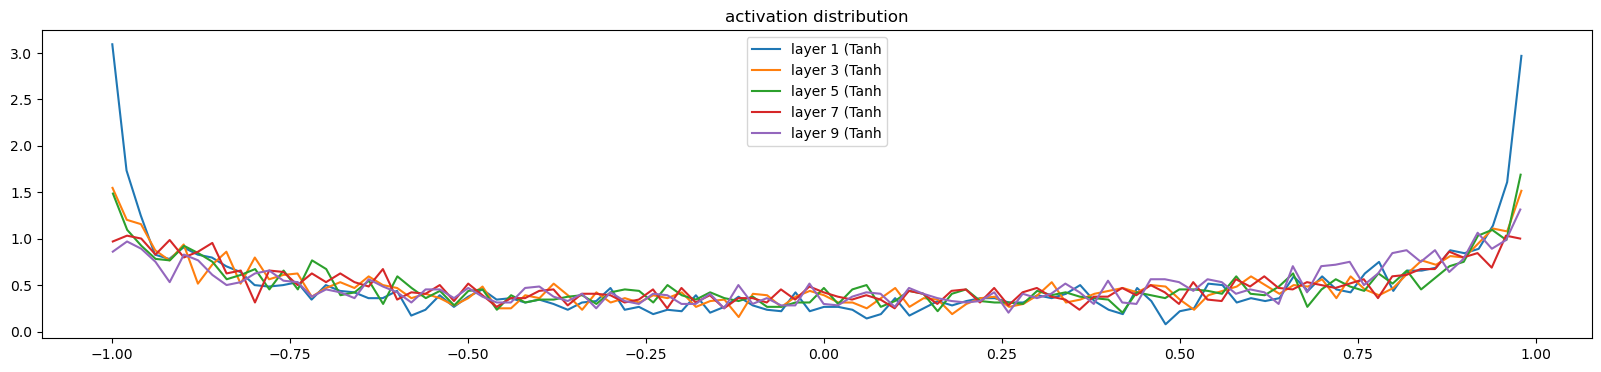

In [106]:
#USING A GAIN OF 5/3

# visualize histograms; OUTPUTS OF TANH LAYER
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

#Saturation >= abs(0.97)


We can see kind of high saturation at the the first layer, but over time it stabilizes to an STD of 0.65 and saturation of 5%. The reason this stabilizes and gives us a nice dist, is because gain = 5/3.

If we dont use any gain ...

layer 1 (      Tanh): mean -0.02, std 0.61, saturated: 2.81%
layer 3 (      Tanh): mean +0.00, std 0.48, saturated: 0.03%
layer 5 (      Tanh): mean -0.00, std 0.42, saturated: 0.00%
layer 7 (      Tanh): mean -0.02, std 0.37, saturated: 0.00%
layer 9 (      Tanh): mean +0.02, std 0.34, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

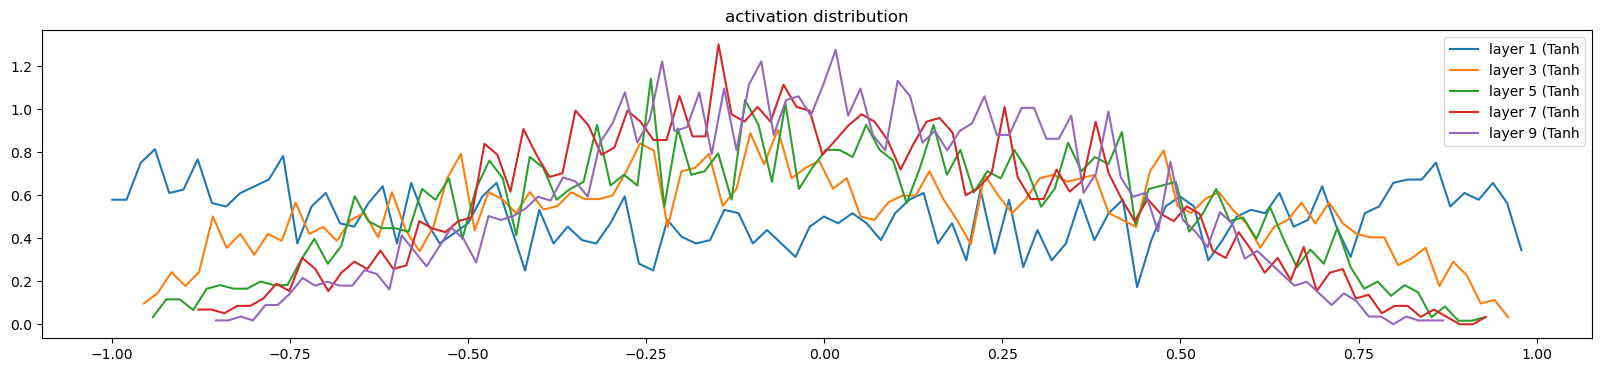

In [109]:
#USING NO GAIN 

# visualize histograms; OUTPUTS OF TANH LAYER
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


We can see without gain, the std is shriking over time and saturation is going to 0. The first layer is pretty decent, but further layers are just shrinking/collapsing to 0. This is because these TanH functions are squashing functions, so initing linear layers with (/ fan_in**0.5) is not sufficient (would be sufficient if only linear layers, see much higher above for reference). Because these TanH functions slightly squash the distribution and so the 5/3 gain is needed to fight the squashing

Note: Use too high of a gain, will cause for their to be too high of a saturation

layer 1 (      Tanh): mean -0.000009, std 4.217608e-04
layer 3 (      Tanh): mean +0.000001, std 4.016694e-04
layer 5 (      Tanh): mean +0.000000, std 3.799102e-04
layer 7 (      Tanh): mean +0.000010, std 3.443295e-04
layer 9 (      Tanh): mean -0.000004, std 3.109050e-04


Text(0.5, 1.0, 'gradient distribution')

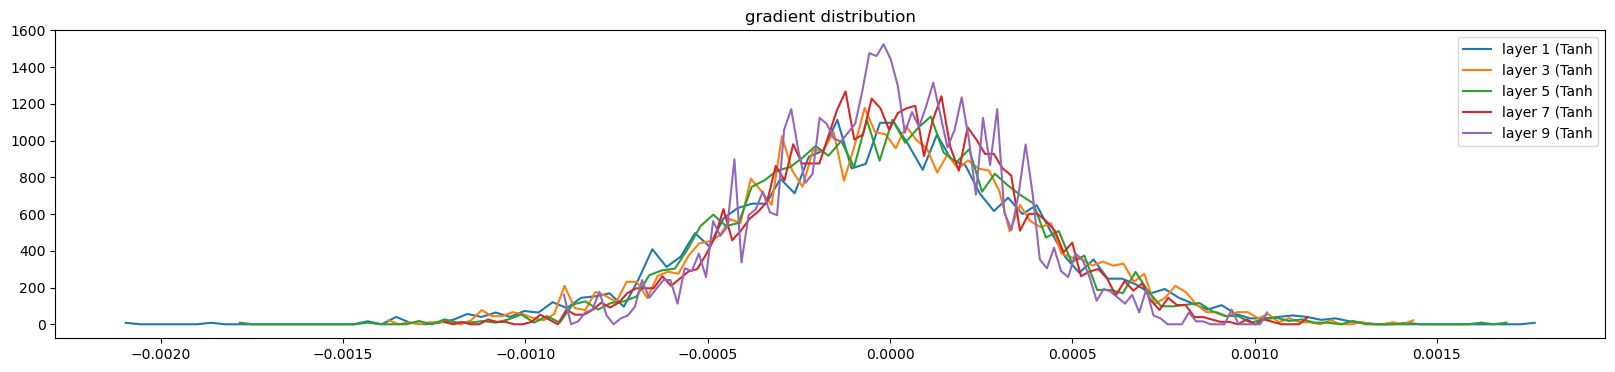

In [113]:
# visualize histograms; gradients OF TANH LAYER
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')


We want all the different layers to have roughly the same gradient, where nothing is shrinking or exploding. If the gain was too small, like 0.5...

layer 1 (      Tanh): mean -0.000000, std 1.866749e-05
layer 3 (      Tanh): mean +0.000001, std 3.792590e-05
layer 5 (      Tanh): mean -0.000000, std 7.732346e-05
layer 7 (      Tanh): mean +0.000005, std 1.545425e-04
layer 9 (      Tanh): mean -0.000004, std 3.109620e-04


Text(0.5, 1.0, 'gradient distribution')

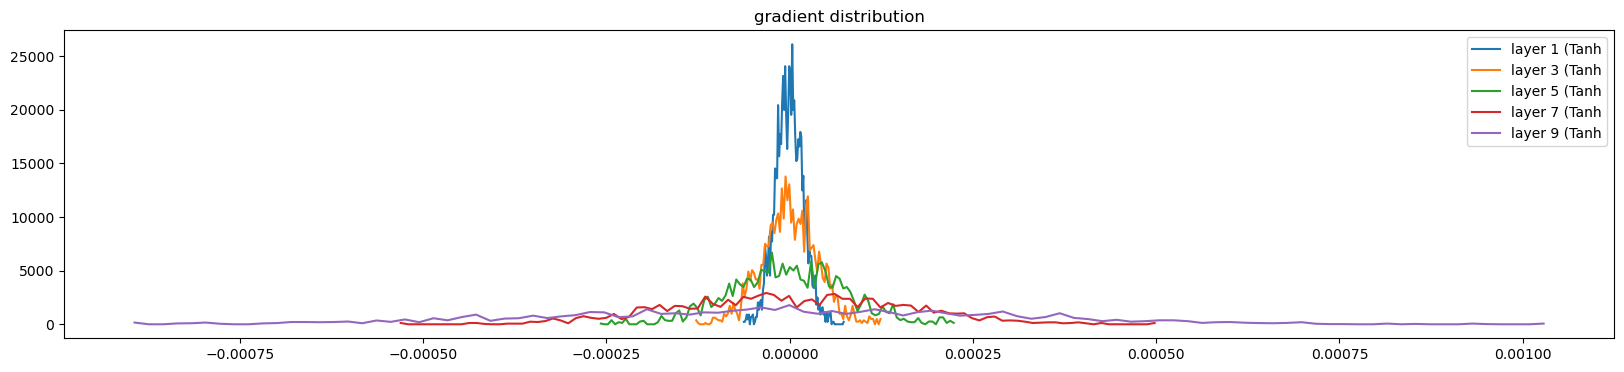

In [116]:
# visualize histograms; gradients OF TANH LAYER
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

Can see the gradients are not consistent across layers (their is asyymetry)

Same problem if the gain is too high

ALL OF THE ABOVE HAS BEEN DONE WITHout BATCHNORM

Note: Stacking linear layers without activations can collapse into a single layer, w.r.t, to its representation power. Interestingly, their training dynamics would be different due to the way the chain rule is calculating it

With non-linearitys, can approx any function

weight   (27, 10) | mean +0.000079 | std 1.301547e-03 | grad:data ratio 1.246774e-03
weight  (30, 100) | mean -0.000006 | std 1.127183e-03 | grad:data ratio 3.663467e-03
weight (100, 100) | mean +0.000001 | std 9.359196e-04 | grad:data ratio 5.596067e-03
weight (100, 100) | mean -0.000005 | std 8.655502e-04 | grad:data ratio 5.191903e-03
weight (100, 100) | mean +0.000001 | std 8.058859e-04 | grad:data ratio 4.825423e-03
weight (100, 100) | mean -0.000004 | std 7.622012e-04 | grad:data ratio 4.532022e-03
weight  (100, 27) | mean -0.000000 | std 2.359861e-02 | grad:data ratio 2.326354e+00


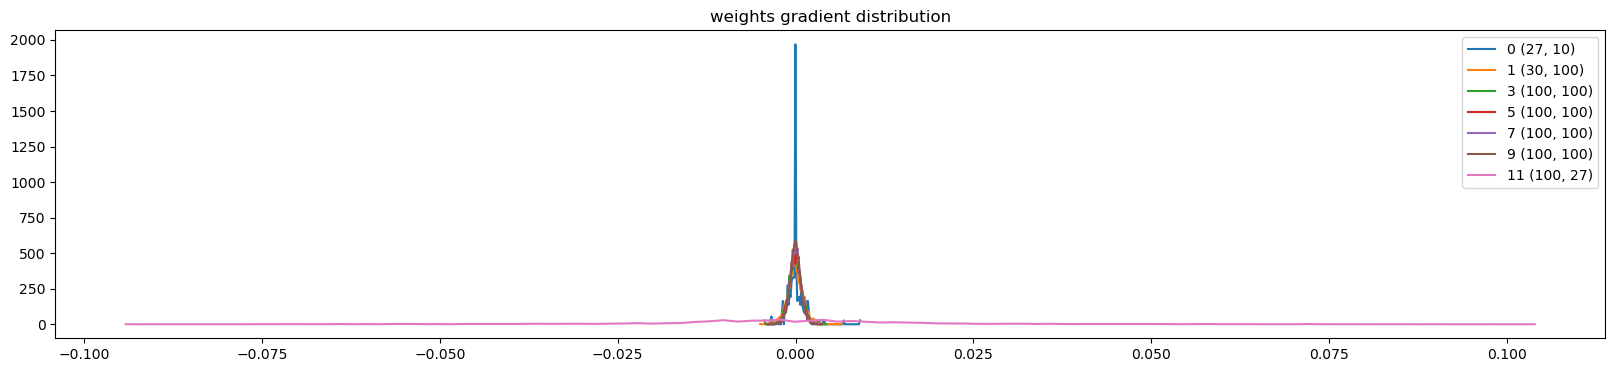

In [119]:
# visualizing only WEIGHTS (no bias) of Linear Layers
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

Grad:Data gives you information about the scale of the gradient to the actual values

If the gradient has too large of a magnitude, compared ot numbers in data, will be in trouble, but in this case, it is low numbers (besides last layer)

Looking at last/output layer, we can see it takes on much larger values then what are inside the NN; which can be seen by its higher SD (10x greater then other weights in NN). this is problematic, because in simple SGD, will be training this last layer 10x faster then training the other layers at init

It will fix to extent, when start to train

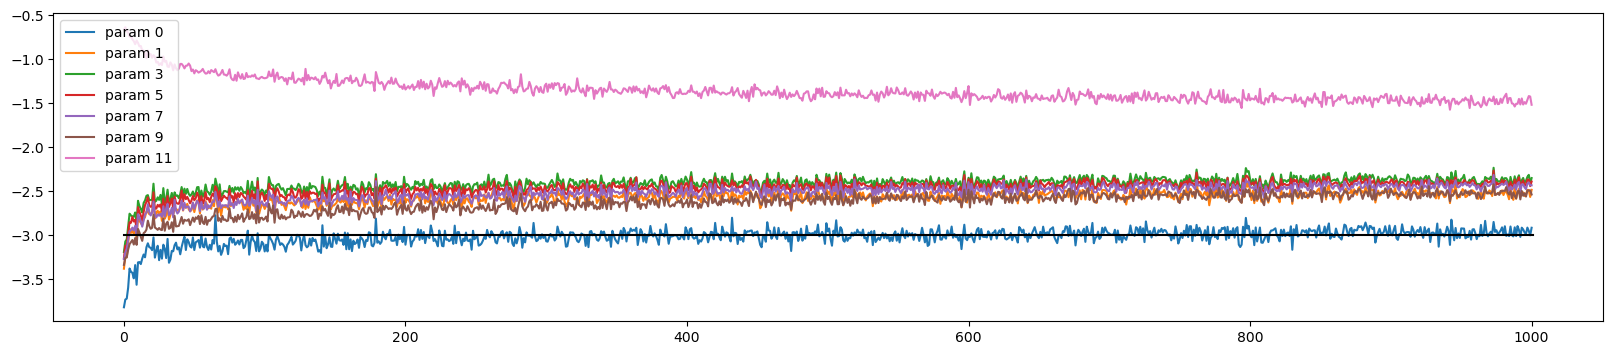

In [125]:
#evolution of update ratio

#Comparing STD of update for a parameter to data/content of the paramater (constrained to W of linear layer)
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # an aprox guide, these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

We can see these ratios evolve over time and stabilize over training

These ratios should be approx 1e-3, w.r.t to update relative value of parameter


The reason the last layer is differnt, is because it was artifically shrunk down to keep the softmax unconfident (i.e multplying by 0.1 at init). This, creates a temp high ratio at start but it does stabilize over time as the weight starts to learn 


If it is less then 1e-3, then params not training fast enough (low LR for instance)

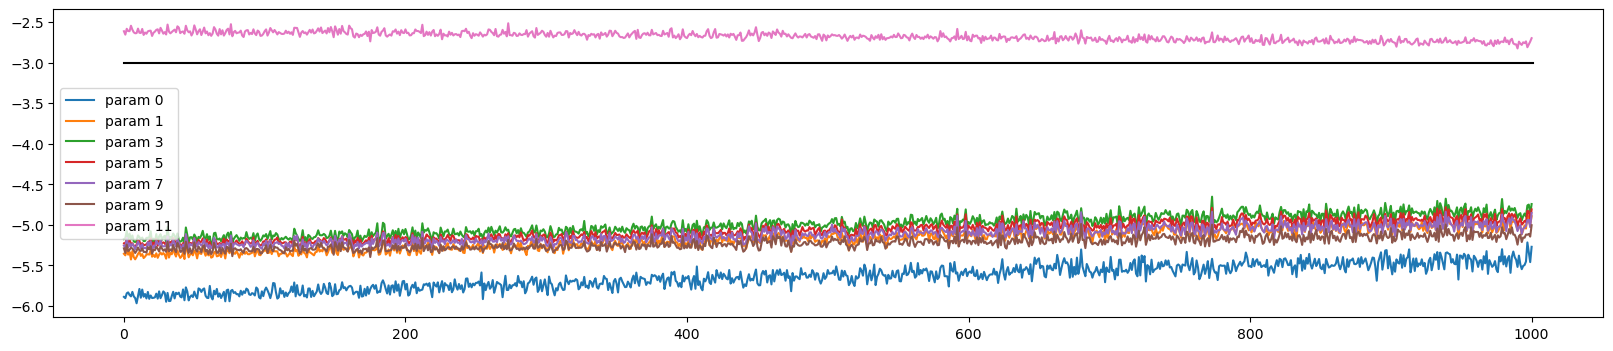

In [128]:
#evolution of update ratio with low LR
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # an aprox guide, these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

If forgot to use fan_in normallization (*= 0.5), lets see how everything gets mess up

layer 1 (      Tanh): mean -0.06, std 0.99, saturated: 97.31%
layer 3 (      Tanh): mean +0.00, std 0.98, saturated: 90.28%
layer 5 (      Tanh): mean +0.02, std 0.98, saturated: 90.59%
layer 7 (      Tanh): mean -0.01, std 0.97, saturated: 89.41%
layer 9 (      Tanh): mean +0.02, std 0.98, saturated: 90.16%


Text(0.5, 1.0, 'activation distribution')

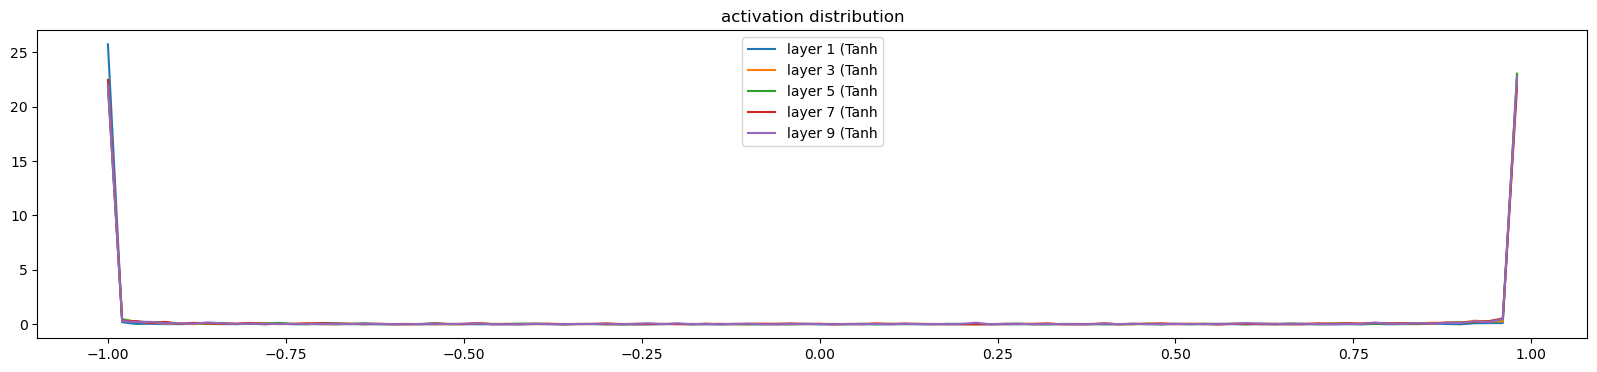

In [134]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

way too saturated

layer 1 (      Tanh): mean -0.002175, std 1.661405e-01
layer 3 (      Tanh): mean +0.000979, std 4.446441e-02
layer 5 (      Tanh): mean -0.000410, std 1.409433e-02
layer 7 (      Tanh): mean -0.000133, std 5.156489e-03
layer 9 (      Tanh): mean -0.000041, std 1.844274e-03


Text(0.5, 1.0, 'gradient distribution')

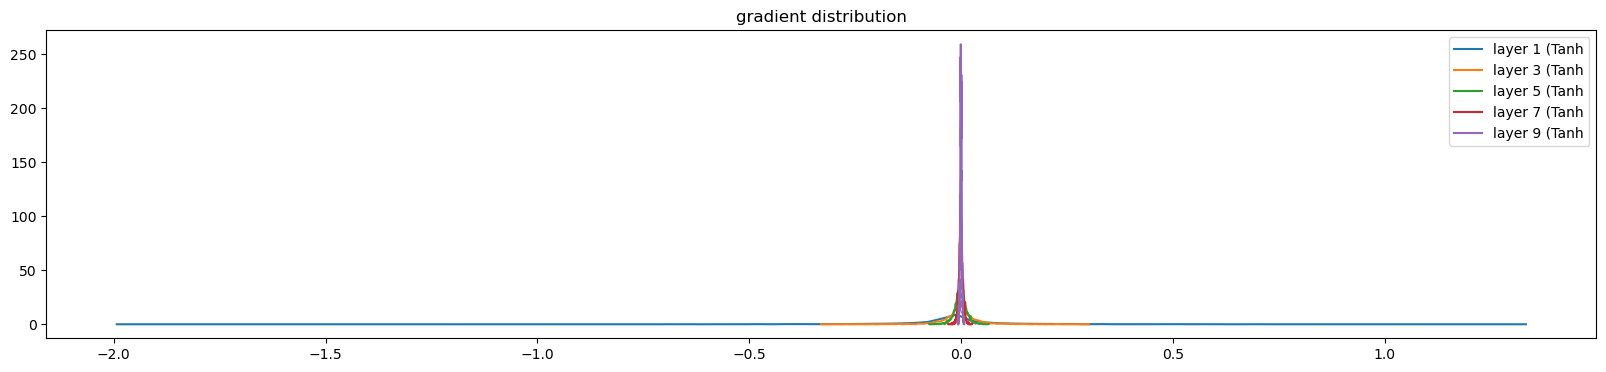

In [135]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.041882 | std 5.995122e-01 | grad:data ratio 2.348383e-01
weight  (30, 100) | mean -0.013310 | std 3.334435e-01 | grad:data ratio 1.714462e-01
weight (100, 100) | mean -0.000622 | std 6.066904e-02 | grad:data ratio 3.607890e-02
weight (100, 100) | mean -0.000129 | std 1.477541e-02 | grad:data ratio 8.857246e-03
weight (100, 100) | mean +0.000024 | std 4.601316e-03 | grad:data ratio 2.754977e-03
weight (100, 100) | mean +0.000001 | std 1.713392e-03 | grad:data ratio 1.018801e-03
weight  (100, 27) | mean -0.000000 | std 3.322429e-02 | grad:data ratio 5.275184e-01


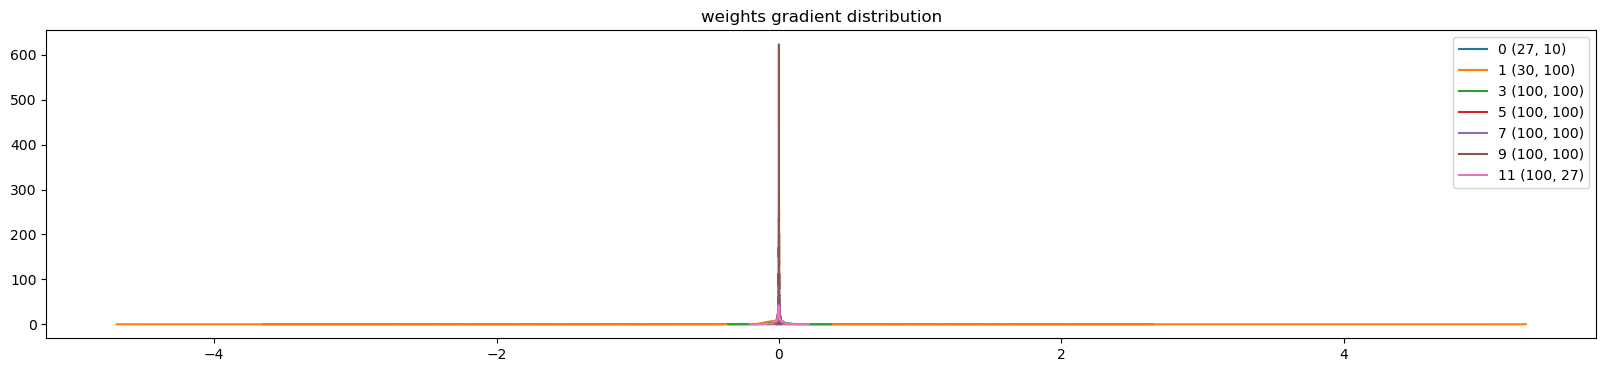

In [136]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

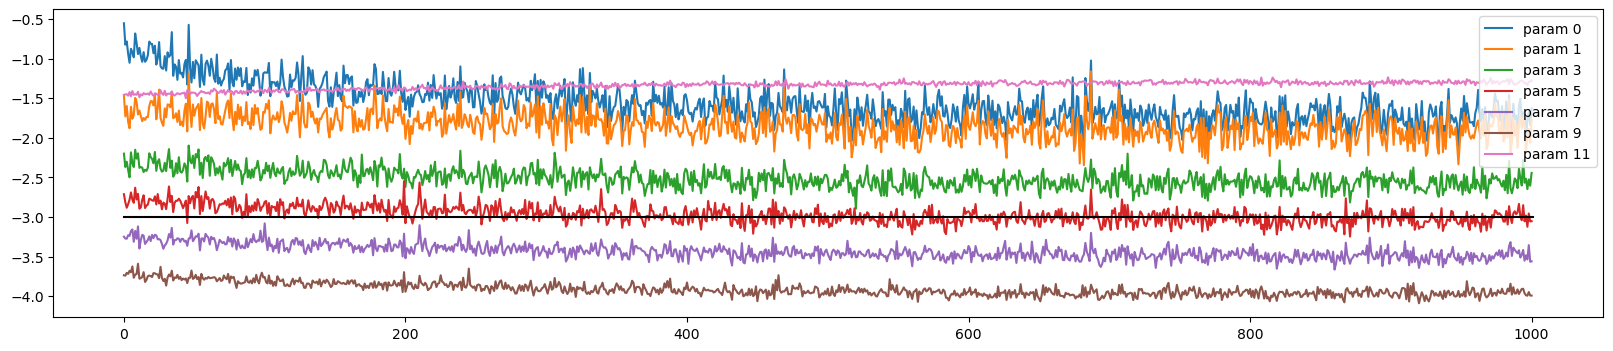

In [137]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # an aprox guide, these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

discrepencies in how fast the layers are learning

ADDING BATCHNORM

In [151]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd))
layers = (
    Linear(n_embd*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, vocab_size), BatchNorm1d(vocab_size),
)

with torch.no_grad():
    #We change gamma in this instance, as gamma scales the output of the norm
    layers[-1].gamma *= 0.1

    #Since using 6 layer MLP, using gain here for init
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # layer.weight *= 5/3
            layer.weight *= 1        

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


47551


In [152]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    #Minibatch Construct

    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #Forward Pass

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    for layer in layers:
        layer.out.retain_grad() #For debugging purposes, keep track of the gradients pertaining to the outputs of each layer

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])

    if i == 1000:
        break

      0/ 200000: 3.2963


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.66%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.53%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 2.19%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.38%


Text(0.5, 1.0, 'activation distribution')

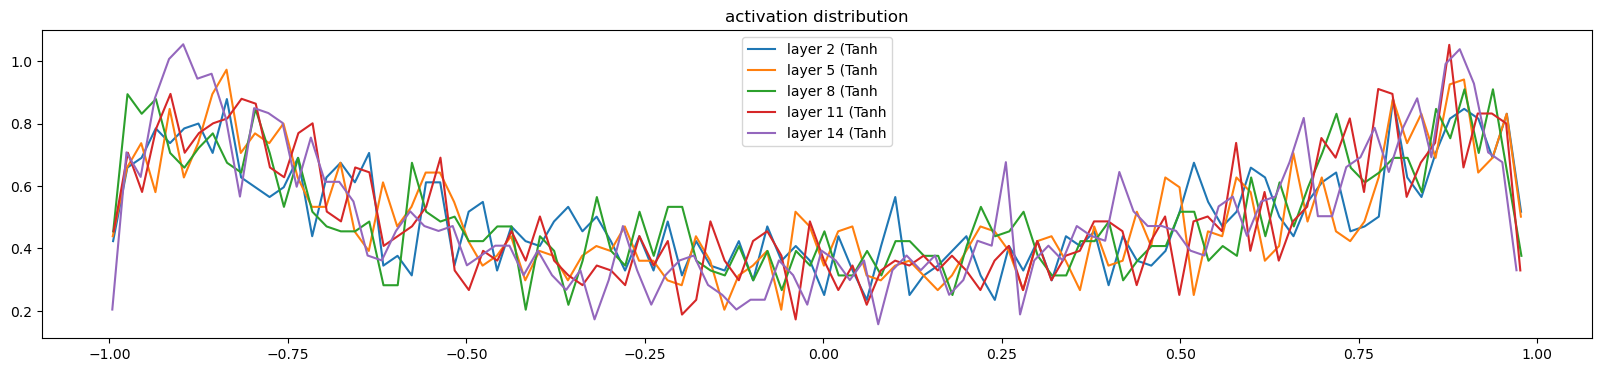

In [153]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


activations look good, because before every tanh layer is their is a normalization due to batchnorm

Roughly equal std throughout all layers

layer 2 (      Tanh): mean -0.000000, std 2.181727e-03
layer 5 (      Tanh): mean -0.000000, std 1.844591e-03
layer 8 (      Tanh): mean +0.000000, std 1.694207e-03
layer 11 (      Tanh): mean +0.000000, std 1.644588e-03
layer 14 (      Tanh): mean +0.000000, std 1.760574e-03


Text(0.5, 1.0, 'gradient distribution')

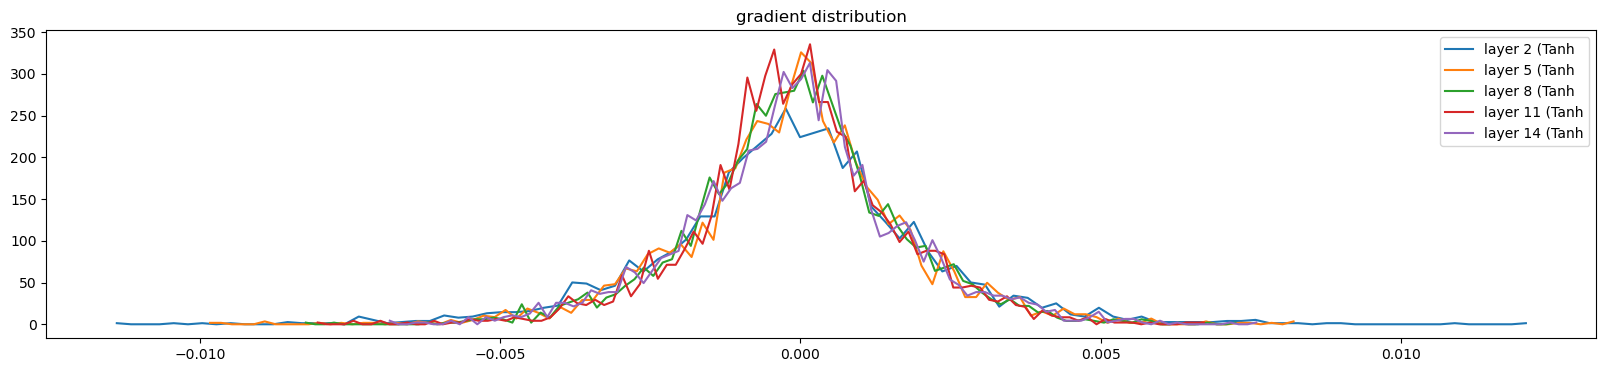

In [154]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 6.810162e-03 | grad:data ratio 6.506195e-03
weight  (30, 100) | mean -0.000090 | std 8.972316e-03 | grad:data ratio 4.798761e-02
weight (100, 100) | mean -0.000005 | std 6.820032e-03 | grad:data ratio 6.626060e-02
weight (100, 100) | mean -0.000076 | std 5.888100e-03 | grad:data ratio 5.776031e-02
weight (100, 100) | mean -0.000043 | std 5.336989e-03 | grad:data ratio 5.239749e-02
weight (100, 100) | mean -0.000073 | std 5.001256e-03 | grad:data ratio 4.887685e-02
weight  (100, 27) | mean -0.000049 | std 1.065014e-02 | grad:data ratio 1.022739e-01


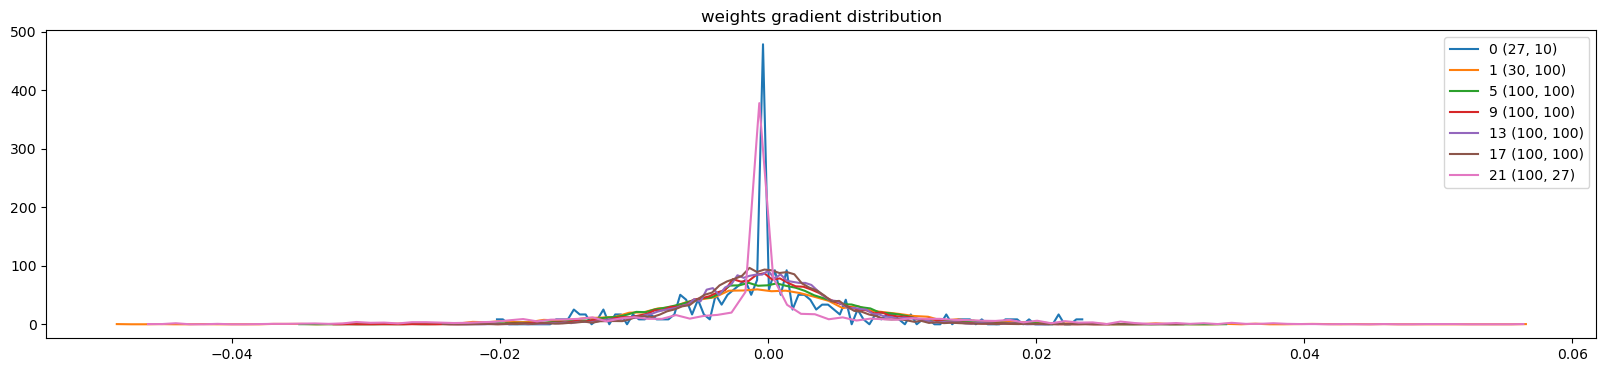

In [155]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

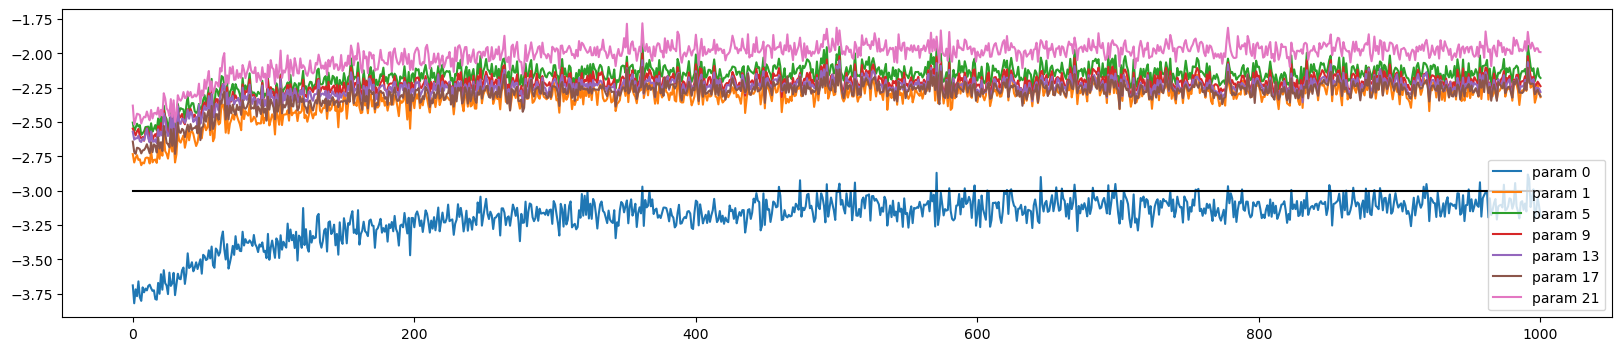

In [156]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

Using batchnorm, we are more robust ot gain of linear layers, whether we need to apply fan_in, we just need to be ware that using differnt gains during init, will interact with batchnorm during backprop, such that it cna lead to different update ratios and in turn optimal LRS (no explanation provided as to why)

The activations of the forward, gradient backward pass, and updates are looking much more well behaved with batchnorm
